In [1]:
from pathlib import Path
import cv2
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
sys.path.append(os.path.dirname(os.getcwd()))

### Load dataset and visualize class distribution

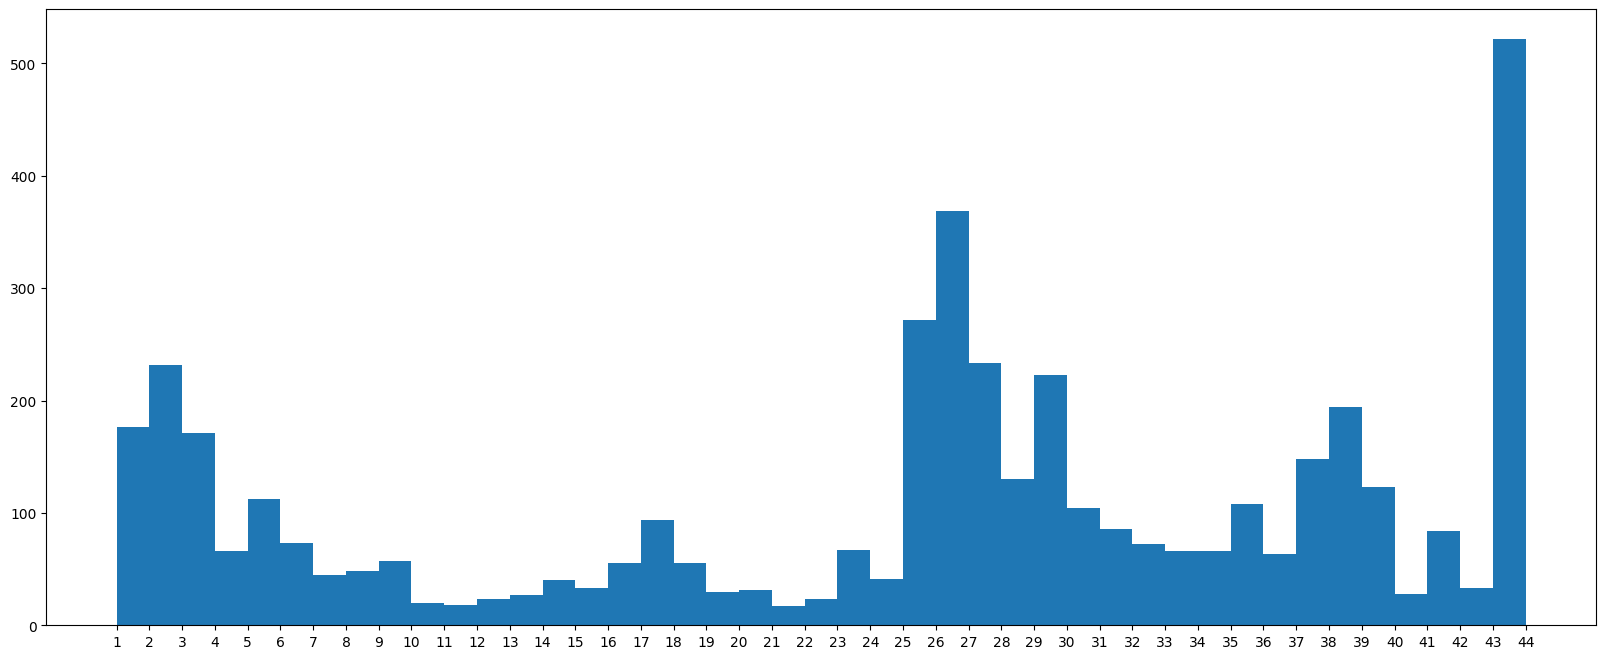

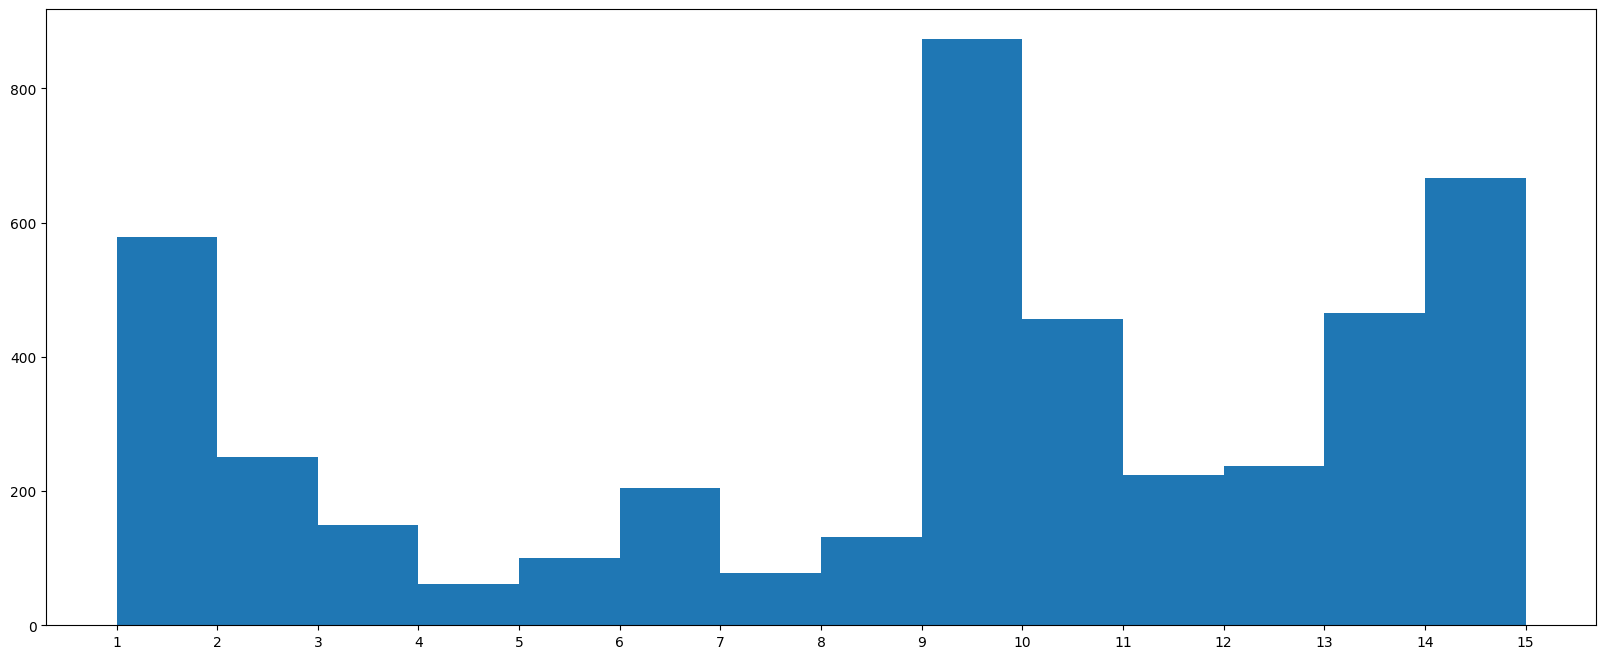

In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "brain_tumor_44_classes")
image_list = [data_path + "/" + folder_name + "/" + fname 
                     for folder_name in os.listdir(data_path)
                     if os.path.isdir(data_path + "/" + folder_name)
                     for fname in os.listdir(data_path+ "/" + folder_name)]
cluster_labels = []
shortened_cluster_labels = []
for folder_name in os.listdir(data_path):
    if os.path.isdir(data_path + "/" + folder_name):
        for fname in os.listdir(data_path+ "/" + folder_name):
            shortened_cluster_labels.append(folder_name.split(" ")[0])
            cluster_labels.append(folder_name)

label_dict = dict(zip(np.unique(cluster_labels), range(1, len(cluster_labels)+2)))
modified_class = [label_dict[label] for label in cluster_labels]
plt.figure(figsize=(20, 8))
plt.hist(modified_class, bins=list(label_dict.values()))
plt.xticks(list(label_dict.values()))
plt.show()

shortened_label_dict = dict(zip(np.unique(shortened_cluster_labels), range(1, len(shortened_cluster_labels)+2)))
shortened_modified_class = [shortened_label_dict[label] for label in shortened_cluster_labels]
plt.figure(figsize=(20, 8))
plt.hist(shortened_modified_class, bins=list(shortened_label_dict.values()))
plt.xticks(list(shortened_label_dict.values()))
plt.show()

### Class imbalance:

With great class imbalance, we plan to:  
+ Firstly combine the images belong to the same superclass  
+ Secondly choose only those with more than 140 images  
+ Cut short of the number of images from dominant superclasses

In [3]:
count_modified_class = list({i:shortened_modified_class.count(i) for i in shortened_modified_class}.items())
chosen_class = [key for key in shortened_label_dict for k, v in count_modified_class if shortened_label_dict[key] == k if v >= 140]
print(chosen_class)

shortened_cluster_labels = []
image_dict = {}
i = 0
count = 0
for folder_name in os.listdir(data_path):
    if os.path.isdir(data_path + "/" + folder_name):
        if folder_name.split(" ")[0] in chosen_class:
            current_class = chosen_class.index(folder_name.split(" ")[0])
            #print("current class:", current_class)
            #print("i:", i)
            if current_class != i:
                i = current_class
                #print("New i:", i)
                count = 0
            for fname in os.listdir(data_path+ "/" + folder_name):
                if count < 200:
                    if folder_name.split(" ")[0] not in image_dict:
                        image_dict[folder_name.split(" ")[0]] = [folder_name + "/" + fname]
                    else:
                        image_dict[folder_name.split(" ")[0]].append(folder_name + "/" + fname)
                    shortened_cluster_labels.append(folder_name.split(" ")[0])
                count += 1

['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Glioblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', '_NORMAL']


### Resize all chosen images to equal size and move them to a different folder

In [4]:
new_data_path = os.path.join(root_path, "shortened_dataset")
if not os.path.exists(new_data_path):
    os.mkdir(new_data_path)
    
new_image_dict = {}
for i in range(len(image_dict.keys())):
    tumor_type = list(image_dict.keys())[i]
    new_name_list = []
    for image_name in image_dict[tumor_type]:
        image_path = os.path.join(data_path, image_name)
        image = cv2.imread(image_path, 0)
        resized_image = cv2.resize(image, (255, 255))
        
        dest = os.path.join(new_data_path, image_name.split('/')[0])
        if not os.path.exists(dest):
            os.mkdir(dest)
        if 'jpeg' in image_name.split('/')[1]:
            new_image_name = image_name.split('/')[1][:-5]+'.png'
        else:
            new_image_name = image_name.split('/')[1][:-4]+'.png'
        
        cv2.imwrite(os.path.join(dest, new_image_name), resized_image)
        new_name_list.append(image_name.split('/')[0] + '/' + new_image_name)
    image_dict[tumor_type] = new_name_list

#### Save chosen filenames as a json

In [5]:
json.dump(image_dict, open(os.path.join(new_data_path, "image_dict.json"), "w"))

### Data augmentations

### Other stuff